In [51]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
from fuzzywuzzy import fuzz

These datasets were pulled from the [National Center for Education Statistics](https://nces.ed.gov/) school finder data tool and the yearly produced report from Denver Public School's [School Performance Framework](http://spf.dpsk12.org/en/). These sets provide information regarding general school characteristics such as number of students, number of teachers, percent of students on free-reduced lunch, percent of students of color, etc. It also provides performance specific information. The performance metrics I will use and their definitions are:

 - __Growth:__ Learning growth of students compared to their peers expressed as a percent
 - __Status:__ Percent of students at grade level
 - __Satisfaction:__ Family and Student survey data about their level of satisfaction with the school
 - __Earned Points:__ The percent of all possible accrued points earned by the school. Primarily a combination of the previous 3 metrics
 
I will be primarily be looking at how the student-teacher ratio impacts these performance metrics between Title I and non-Title I schools.

In [2]:
#read in the school performance data
spf_data = pd.read_csv('2017_DPS_SPF.csv')

#make the columns easier to manage
spf_data.rename(columns={'SPF School Name' : 'School Name',
                         '% Earned Points' : 'earned_points',
                         'Student Progress - Growth' : 'growth',
                         'Student Achivement - Status' : 'status',
                         'Family and Student Engagement & Satisfaction' : 'satisfaction',
                         '% FRL' : 'frl',
                         '% Students Of Color' : 'students_of_color',
                         '% ELL' : 'ell',
                         '% SPED' : 'sped',
                         'Network' : 'network',
                         'Board District' : 'board_district'},
                          inplace=True)

In [3]:
#only choose the columns needed and drop null values
spf_data_refined = spf_data.loc[:, ['School Name', 'earned_points', 'growth', 'status', 'satisfaction', 'frl', 'students_of_color', 'ell', 'sped', 'board_district', 'network']]
spf_data_refined = spf_data_refined.dropna(how='all')

#We will be merging this data with the NCES/dps data and need to clean it
spf_data_refined['School Name'] = spf_data_refined['School Name'].apply(lambda x: x.lower().strip())
spf_data_refined['School Name'] = spf_data_refined['School Name'].apply(lambda  x: x.replace('ms', 'middle school'))
spf_data_refined['School Name'] = spf_data_refined['School Name'].apply(lambda  x: x.replace('hs', 'high school'))
spf_data_refined['School Name'] = spf_data_refined['School Name'].apply(lambda  x: x.replace('.', ''))


In [52]:
#load in the NCES/dps specific data
dps_data = pd.read_csv('dps_data.csv', encoding = "ISO-8859-1")

#only choose the columns we need
dps_data_refined = dps_data.loc[:, ['School Name', 'Title I School*', 'Students*', 'Teachers*', 'Student Teacher Ratio*', 'Free Lunch*', 'Reduced Lunch*']]

#make some columns easier to read
dps_data_refined.rename(columns={'Title I School*' : 'title_I',
                   'Students*' : 'students',
                   'Teachers*' : 'teachers',
                   'Student Teacher Ratio*' : 'student_teacher_ratio', 
                   'Free Lunch*' : 'free_lunch',
                   'Reduced Lunch*' : 'reduced_lunch'},
                    inplace=True)

#cleaning the data for merging purposes
dps_data_refined['School Name'] = dps_data_refined['School Name'].apply(lambda x: x.lower().strip())
dps_data_refined['School Name'] = dps_data_refined['School Name'].apply(lambda x: x.replace('.', ''))

In [53]:
#merge the two df's - 'temporary' because we'll want to fuzzy match and merge again
temp_df = spf_data_refined.merge(dps_data_refined, left_on='School Name', right_on='School Name', how='inner')

temp_df.head()

,School Name,earned_points,growth,status,satisfaction,frl,students_of_color,ell,sped,board_district,network,title_I,students,teachers,student_teacher_ratio,free_lunch,reduced_lunch
0,steck elementary school,92.22%,95%,94%,54%,13.5%,27.0%,12.1%,5.5%,NNE,Network 5,No,348.00000,19.49000,17.9000000,42.00000,5.00000
1,slavens k-8 school,92.10%,92%,96%,78%,6.8%,17.7%,3.8%,5.2%,SE,Network 4,No,711.00000,40.31000,17.6000000,36.00000,12.00000
2,strive prep - rise,91.74%,89%,100%,90%,86.6%,94.4%,78.2%,9.9%,FNE,Charter/Contract,No,142.00000,7.43000,19.1000000,97.00000,26.00000
3,kipp northeast denver leadership academy,90.51%,91%,88%,83%,86.2%,93.6%,64.9%,11.3%,FNE,Charter/Contract,Yes,282.00000,20.05000,14.1000000,198.00000,45.00000
4,dsst: byers middle school,89.89%,90%,93%,71%,38.8%,49.3%,27.5%,7.7%,SE,Charter/Contract,No,469.00000,31.26000,15.0000000,141.00000,41.00000


In [54]:
len(temp_df) / len(spf_data_refined) * 100

83.2512315270936

Looks like we're only matching 83% of the schools in our framework. Let's try some fuzzy matching!

In [55]:
#create a df of all the schools that haven't matched
no_match = spf_data_refined[~spf_data_refined['School Name'].isin(temp_df['School Name'])]

In [56]:
#create a function for fuzzy matching
def find_match():
    #iterate through each non-match name and find matches > 95% then change the name of the dps data -> name of non-match
    for name in no_match['School Name']:
        for i in dps_data_refined['School Name']:
            if (fuzz.token_set_ratio(name, i) > 95):
                dps_data_refined.loc[dps_data_refined['School Name'] == i, 'School Name'] = name
find_match()

In [57]:
#create a new df my merging our new matches with our newly changed dps_data_refined data
no_match_df = no_match.merge(dps_data_refined, left_on='School Name', right_on='School Name', how='inner')

In [58]:
#add the manually cleaned data with our 'fuzzy' cleaned data
df = pd.concat([temp_df, no_match_df], sort=False)

In [59]:
len(df) / len(spf_data_refined) * 100

94.08866995073892

#### Alright! We're matching a little over 94%. Let's do a little more cleaning and then we'll do some analysis.

In [60]:
#Remove the percent sign and convert all to a float
def replace_percent(column):
    df[column] = df[column].apply(lambda x: x.replace('%', '') if type(x) == str else float(x))
    df[column] = df[column].astype(float)
    
replace_percent('earned_points')
replace_percent('growth')
replace_percent('status')
replace_percent('satisfaction')
replace_percent('frl')
replace_percent('students_of_color')
replace_percent('ell')
replace_percent('sped')

In [61]:
#convert all to float
def to_float(column):
    df[column] = df[column].astype(float)
    
to_float('students')
to_float('teachers')
to_float('student_teacher_ratio')
to_float('free_lunch')
to_float('reduced_lunch')

In [62]:
df = df.dropna(how='any')

#### Now that our data is cleaned-up, let's start doing some analysis!

In [63]:
df.head()

,School Name,earned_points,growth,status,satisfaction,frl,students_of_color,ell,sped,board_district,network,title_I,students,teachers,student_teacher_ratio,free_lunch,reduced_lunch
0,steck elementary school,92.22,95.0,94.0,54.0,13.5,27.0,12.1,5.5,NNE,Network 5,No,348.0,19.49,17.9,42.0,5.0
1,slavens k-8 school,92.10,92.0,96.0,78.0,6.8,17.7,3.8,5.2,SE,Network 4,No,711.0,40.31,17.6,36.0,12.0
2,strive prep - rise,91.74,89.0,100.0,90.0,86.6,94.4,78.2,9.9,FNE,Charter/Contract,No,142.0,7.43,19.1,97.0,26.0
3,kipp northeast denver leadership academy,90.51,91.0,88.0,83.0,86.2,93.6,64.9,11.3,FNE,Charter/Contract,Yes,282.0,20.05,14.1,198.0,45.0
4,dsst: byers middle school,89.89,90.0,93.0,71.0,38.8,49.3,27.5,7.7,SE,Charter/Contract,No,469.0,31.26,15.0,141.0,41.0


In [64]:
df.describe()

,earned_points,growth,status,satisfaction,frl,students_of_color,ell,sped,students,teachers,student_teacher_ratio,free_lunch,reduced_lunch
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,56.862053,58.363158,50.578947,50.136842,70.002632,78.613158,40.014737,11.279474,465.200000,30.059789,15.523684,269.984211,43.289474
std,15.396140,15.434439,24.405776,18.928219,26.714599,23.387447,23.483909,4.632260,289.720175,16.864907,3.135396,185.713396,31.833485
min,21.310000,22.000000,0.000000,0.000000,3.900000,16.700000,0.000000,1.600000,63.000000,4.660000,6.100000,6.000000,1.000000
25%,46.260000,47.250000,33.000000,38.000000,54.750000,67.650000,20.625000,8.125000,299.500000,20.007500,14.125000,122.250000,21.000000
50%,55.600000,58.000000,49.000000,50.000000,81.800000,90.650000,40.450000,10.350000,416.000000,28.000000,15.500000,244.500000,36.000000
75%,66.495000,69.750000,68.000000,64.500000,90.850000,95.675000,58.775000,13.975000,538.750000,35.957500,16.900000,359.500000,56.750000
max,92.220000,95.000000,100.000000,92.000000,97.600000,99.100000,91.000000,32.700000,2543.000000,134.100000,33.000000,952.000000,172.000000


Let's take a look at how student-teacher ratio affects school's performance.

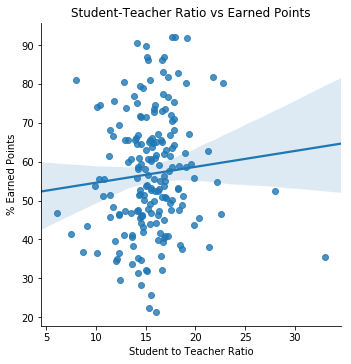

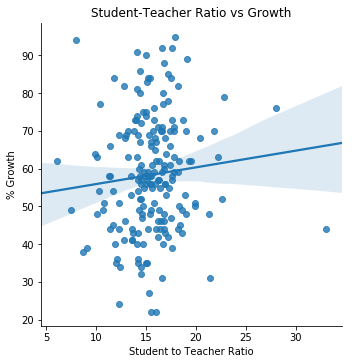

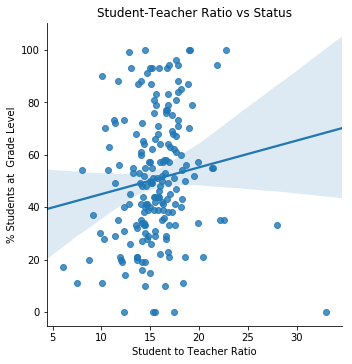

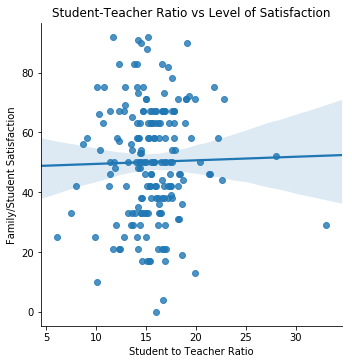

In [65]:
#plot s-t ratio and earned points
sns.lmplot(x='student_teacher_ratio',
           y='earned_points',
           data=df)
plt.title('Student-Teacher Ratio vs Earned Points')
plt.ylabel('% Earned Points')
plt.xlabel('Student to Teacher Ratio')

#plot s-t ratio and growth
sns.lmplot(x='student_teacher_ratio',
           y='growth',
           data=df)
plt.title('Student-Teacher Ratio vs Growth')
plt.ylabel('% Growth')
plt.xlabel('Student to Teacher Ratio')

#plot s-t ratio and status
sns.lmplot(x='student_teacher_ratio',
           y='status',
           data=df)
plt.title('Student-Teacher Ratio vs Status')
plt.ylabel('% Students at  Grade Level')
plt.xlabel('Student to Teacher Ratio')

plt.show()

#plot s-t ratio and satisfaction
sns.lmplot(x='student_teacher_ratio',
           y='satisfaction',
           data=df)
plt.title('Student-Teacher Ratio vs Level of Satisfaction')
plt.ylabel('Family/Student Satisfaction')
plt.xlabel('Student to Teacher Ratio')

plt.show()

This was unexpected! It looks like there's a positive correlation between student-teacher ratio and our performance metrics. Let's see how strong these relationships are.

In [66]:
def get_r_squared(df, col1, col2):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[col1], df[col2])
    print('The r_squared value between {} and {} is {}'.format(col1, col2, r_value**2))

In [67]:
get_r_squared(df ,'student_teacher_ratio', 'earned_points')
get_r_squared(df, 'student_teacher_ratio', 'status')
get_r_squared(df, 'student_teacher_ratio', 'growth')
get_r_squared(df, 'student_teacher_ratio', 'satisfaction')

The r_squared value between student_teacher_ratio and earned_points is 0.0069109120310095265
The r_squared value between student_teacher_ratio and status is 0.01715361704151209
The r_squared value between student_teacher_ratio and growth is 0.0080665705535431
The r_squared value between student_teacher_ratio and satisfaction is 0.0003902561961048603


These seem to be pretty weak correlations, but present nonetheless. I wonder what happens when we compare Title I schools with non-Title I schools?

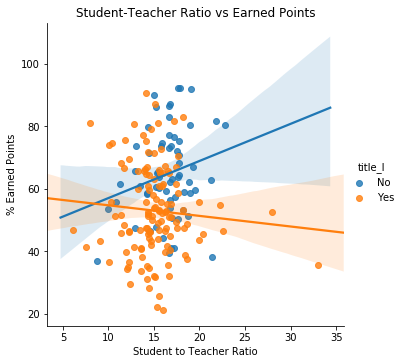

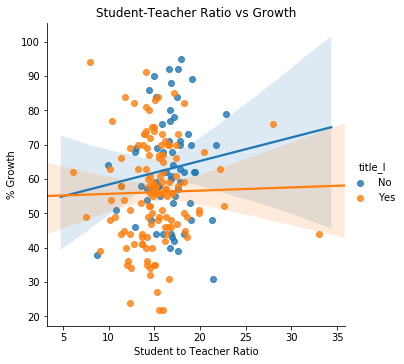

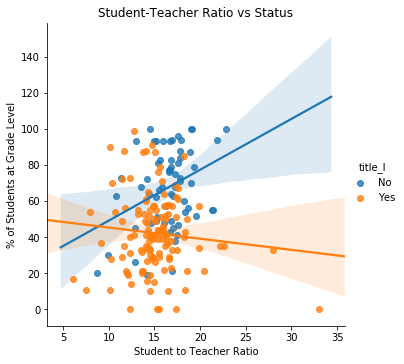

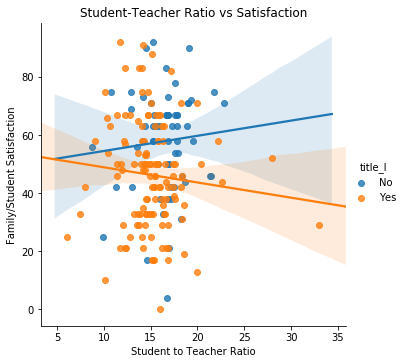

In [68]:
#plot s-t ratio and earned points
sns.lmplot(x='student_teacher_ratio',
           y='earned_points',
           hue='title_I',
           data=df)
plt.title('Student-Teacher Ratio vs Earned Points')
plt.ylabel('% Earned Points')
plt.xlabel('Student to Teacher Ratio')

plt.show()

#plot s-t ratio and growth
sns.lmplot(x='student_teacher_ratio',
           y='growth',
           hue='title_I',
           data=df)
plt.title('Student-Teacher Ratio vs Growth')
plt.ylabel('% Growth')
plt.xlabel('Student to Teacher Ratio')

plt.show()

#plot s-t ratio and status
sns.lmplot(x='student_teacher_ratio',
           y='status',
           hue='title_I',
           data=df)
plt.title('Student-Teacher Ratio vs Status')
plt.ylabel('% of Students at Grade Level')
plt.xlabel('Student to Teacher Ratio')

plt.show()

#plot s-t ratio and satisfaction
sns.lmplot(x='student_teacher_ratio',
           y='satisfaction',
           hue='title_I',
           data=df)
plt.title('Student-Teacher Ratio vs Satisfaction')
plt.ylabel('Family/Student Satisfaction')
plt.xlabel('Student to Teacher Ratio')

plt.show()

Interesting! It seems there is a negative correlation between Title I school and the student-teacher ratio for all metrics except growth! Let's see how strong these relationships are between these results.

In [69]:
#df of title I schools
title = df.loc[df.title_I == 'Yes']
#df of non-title I schools
no_title = df.loc[df.title_I == 'No']

Let's make sure that there isn't any major outliers or issues with the spread of our performance metrics.

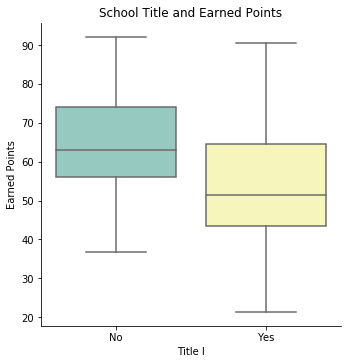

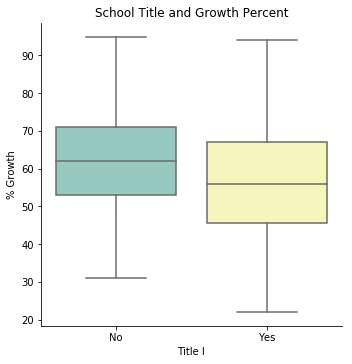

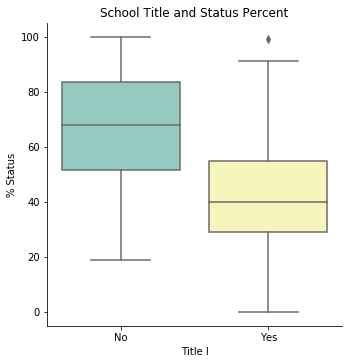

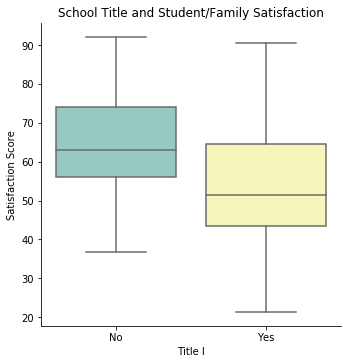

In [71]:
#create box plots by title status and performance for earned points, growth, status, Family/Student Satisfaction
sns.catplot(x='title_I', 
            y='earned_points', 
            kind='box',
            data=df,
            palette='Set3')
plt.title('School Title and Earned Points')
plt.xlabel('Title I')
plt.ylabel('Earned Points')

plt.show()

sns.catplot(x='title_I', 
            y='growth', 
            kind='box',
            data=df,
            palette='Set3')
plt.title('School Title and Growth Percent')
plt.xlabel('Title I')
plt.ylabel('% Growth')

plt.show()

sns.catplot(x='title_I', 
            y='status', 
            kind='box',
            data=df,
            palette='Set3')
plt.title('School Title and Status Percent')
plt.xlabel('Title I')
plt.ylabel('% Status')

plt.show()

sns.catplot(x='title_I', 
            y='earned_points', 
            kind='box',
            data=df,
            palette='Set3')
plt.title('School Title and Student/Family Satisfaction')
plt.xlabel('Title I')
plt.ylabel('Satisfaction Score')

plt.show()

So, it seems there is only one outlier among Title I school and status. Overall, these amounts should be ok to use as is!

#### Title I Schools R-squared Values

In [49]:
get_r_squared(title ,'student_teacher_ratio', 'earned_points')
get_r_squared(title, 'student_teacher_ratio', 'status')
get_r_squared(title, 'student_teacher_ratio', 'growth')
get_r_squared(title, 'student_teacher_ratio', 'satisfaction')

The r_squared value between student_teacher_ratio and earned_points is 0.005850615234600752
The r_squared value between student_teacher_ratio and status is 0.00907664078586007
The r_squared value between student_teacher_ratio and growth is 0.00041418912992011885
The r_squared value between student_teacher_ratio and satisfaction is 0.008538661789899314


#### Non-Title I Schools R-sqaured Values

In [50]:
get_r_squared(no_title ,'student_teacher_ratio', 'earned_points')
get_r_squared(no_title, 'student_teacher_ratio', 'status')
get_r_squared(no_title, 'student_teacher_ratio', 'growth')
get_r_squared(no_title, 'student_teacher_ratio', 'satisfaction')

The r_squared value between student_teacher_ratio and earned_points is 0.047771453487833376
The r_squared value between student_teacher_ratio and status is 0.11642958620919017
The r_squared value between student_teacher_ratio and growth is 0.013822716313630247
The r_squared value between student_teacher_ratio and satisfaction is 0.0062060832481461645


These relationships seem stronger than our overall dataset. There seems to be some decent evidence to perform an A-B test!

## Research Proposal

__The Problem:__
I don't think the importance of a healthy education system needs defending. The differences between achivement between low-income and affluent students is concerning, specifically how this [trend is self perpetuating](https://www.sciencenews.org/article/learning-gap-rich-poor-students-remains-high).

__The Hypothesis:__
So what can be done within Denver Public Schools? As the above data show, schools with a high population of low-income students perform slightly better when they have a lower student-to-teacher ratio. I believe that decreasing the student-to-teacher ratio among low-income school will improve learning outcomes and student/family satisfaction which will directly affect overall school performance.

__Method of testing:__
I believe a gradual rollout will yield favorable results. We will implement the change in 10% of schools in the first year, then scale up to 30% the second year, and finally 50% by the third year. The final results will be compiled after 5 years. This will take considerable time and there are a few reasons for this decision. 

First, the reason for a gradual rollout is that, within the current structure of the school performance framework, results are released only once per year. A gradual rollout will allow us the flexibility to cease the study if we see unfavorable results. 

Second, its assumed that positive results will take time. For example, 5 years ensures that a high school will have a cohort of students throughout the length of the experiment. Having one cohort also allows K-8, elementary, and middle schools the same status (please note that students are first evaluated in 3rd grade).

Our primary metric for success will be a school's earned points. Secondary metrics include the school's growth, status, and satisfaction (all of which contribute to the overall school's earned points).

Our benchmarks for success will be an overall increase in the test group's earned points by one standard deviation by the end of the 5th year. We will evaluate all metrics annually. The test will continue so long as we don't see an overall decrease in school's earned points and a decrease in 2 of the 3 secondary metrics.

We also must be conscious when choosing our two groups. We need to evenly split by factors including overall school funding, percent of ell students, percent of sped students, percent of students of color, percent of free reduced lunch, and regionally throughout the city (as represented by school's board district). 